# Query Transformations

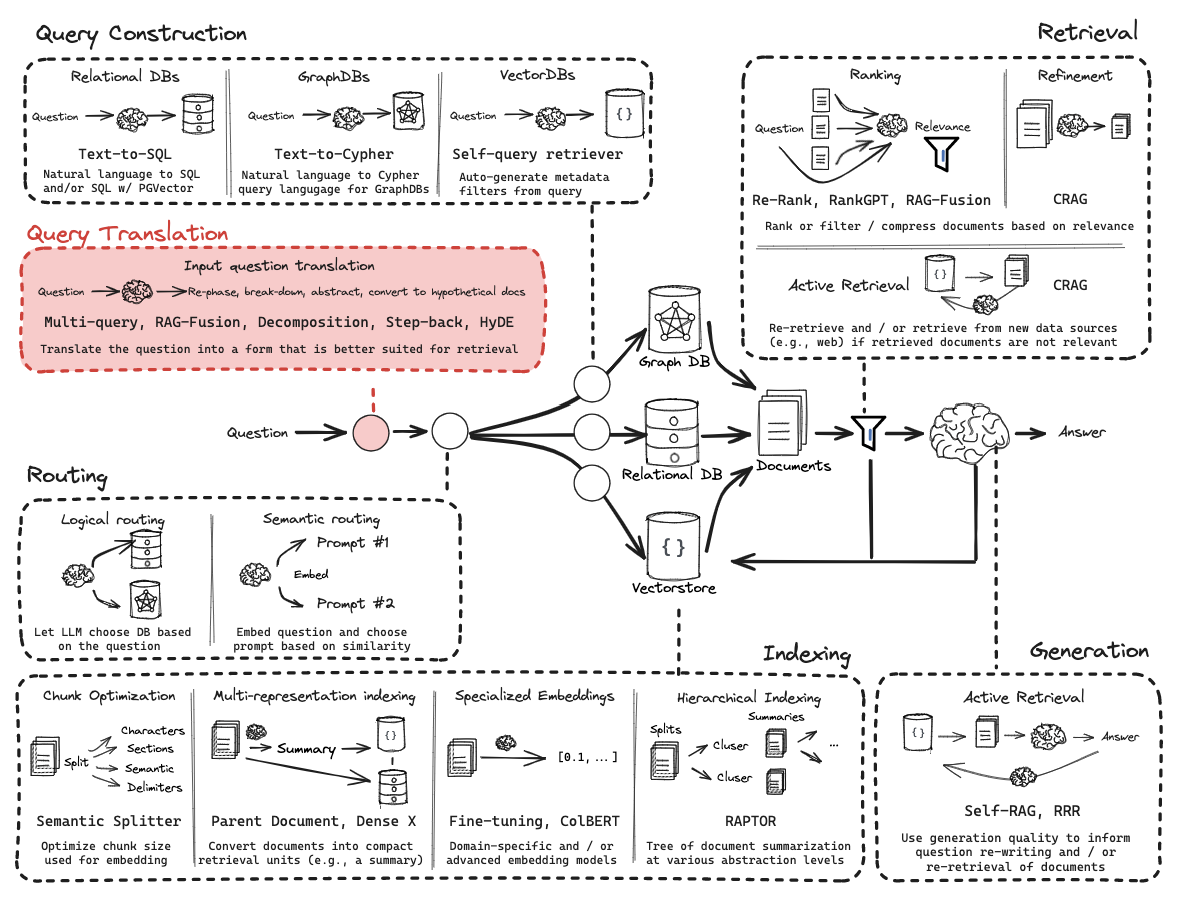

Query Transformations 是一系列专注于重写/修改检索查询的方法。

传统 RAG 的流程很直：用户问题 → 向量检索 → 拼接上下文 → LLM 作答。
但现实里，检索经常翻车，原因很多，比如：

- 问题太短/太抽象，向量检索抓不到关键点
- 只问一种表述，语义相近但“角度不同”的文档没被召回
- 一个复杂问题其实需要拆成多个子问题逐个查
- 问题中的实体或概念过具体，反而不利于找到“更一般”的背景知识

所以下面我们用 5 种 Query Transformation 思路来提升检索：

1. Multi Query：同一问题生成多种问法，多路召回再合并
2. RAG-Fusion：多路召回后用 Reciprocal Rank Fusion（RRF）做“融合重排”
3. Decomposition：把复杂问题拆成子问题（递归式 / 分别回答后综合）
4. Step Back：先“退一步”问更抽象的问题拿背景，再回到原问题
5. HyDE：先让 LLM 写一段“假想答案文档”，用这段文档去检索

In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL")

下面我们先进行一个公共的Indexing流程，后面的检索都围绕下面的retriever展开。

In [2]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

loader = TextLoader(r"E:\users\hwy\LLMs-Technology-Projects\LangChain_AI_Learning\data\员工手册.md", encoding="utf-8")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50
)
text_splits = text_splitter.split_documents(docs)

embed = HuggingFaceEmbeddings(
    model_name=r"E:\users\hwy\LLMs-Technology-Projects\models\Dmeta-embedding-zh",
    model_kwargs={"device": "cpu"}
)
vector_store = Chroma.from_documents(documents=text_splits, embedding=embed)
retriever = vector_store.as_retriever()

e:\users\hwy\LLMs-Technology-Projects\LangChain_AI_Learning\langchain\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <mark>1. Multi Query (多查询视角召回)</mark>

核心想法:

同一个问题，让 LLM 生成多个“不同角度”的改写问题，分别检索，然后把结果合并去重。

这能对抗“单一问法导致召回盲区”。

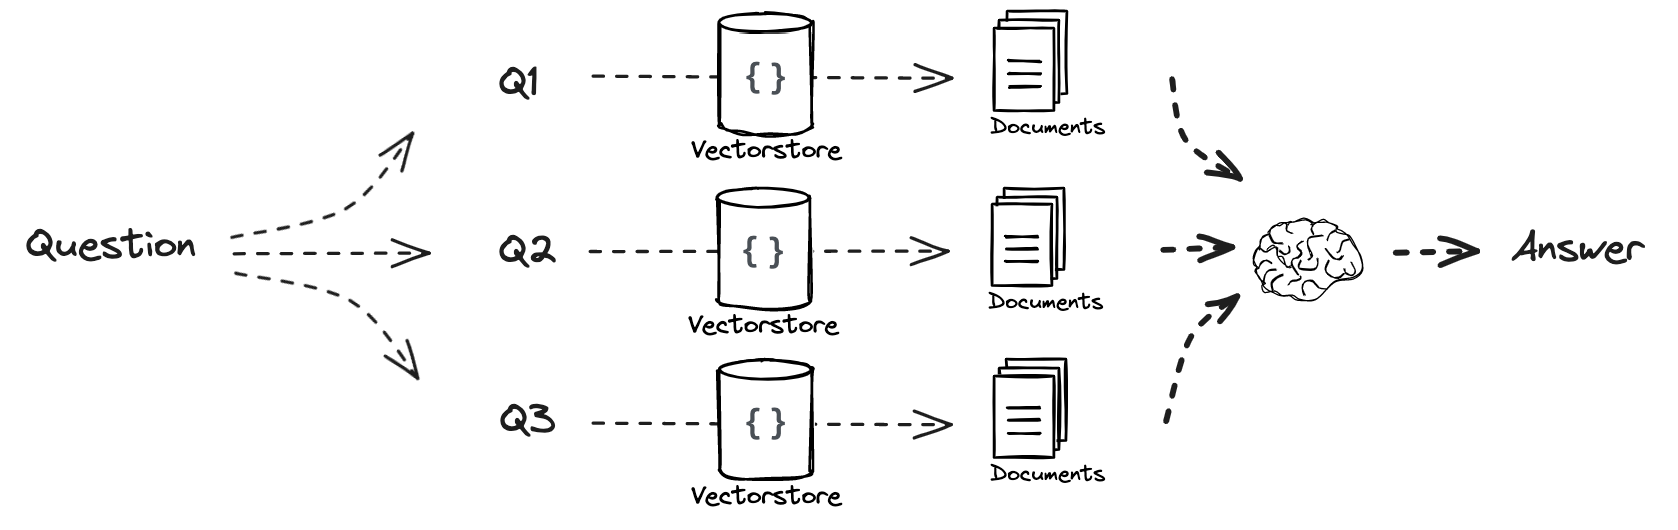

### 1.1 生成 5 个不同版本的问题

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# template = """You are an AI language model assistant. Your task is to generate five 
# different versions of the given user question to retrieve relevant documents from a vector 
# database. By generating multiple perspectives on the user question, your goal is to help
# the user overcome some of the limitations of the distance-based similarity search. 
# Provide these alternative questions separated by newlines. Original question: {question}"""

template = """你是一个用于信息检索的AI助手。请给予给定的用户问题，生成5个语义等价但表达方式不同的问题，以用于向量数据库的多路检索 (Multi-Query Retrieval)。

通过从不同角度改写用户问题，你的目标是帮助用户客服基于向量距离相似度搜索所存在的局限性，从而提高检索的召回率与覆盖面。

请将生成的多个问题逐行输出，每行一个问题，不要添加编号或额外说明。

用户原始问题：{question}
"""

prompt_perspectives = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    model="gpt-5-mini",
    temperature=0
)

generative_queries = (
    prompt_perspectives
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)
# 输出是一个字符串列表（5行），每行是一个改写问题

### 1.2 对每个改写问题做检索，并合并去重

In [4]:
from langchain_core.load import dumps, loads

def get_unique_union(documents: list[list]):
    """对检索结果进行去重合并"""
    # 将多层列表展开，并将每个 Document 对象序列化为字符串
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # 对文档进行去重
    unique_docs = list(set(flattened_docs))
    # 反序列化并返回去重后的文档列表
    return [loads(doc) for doc in unique_docs]

# 执行检索
question = "员工如果经常迟到会怎么处罚？"
# 公司允许员工搞副业吗？
# 我可以带朋友来公司参观吗？
retrieval_chain = generative_queries | retriever.map() | get_unique_union

docs = retrieval_chain.invoke({"question": question})
len(docs)

C:\Users\后文越\AppData\Local\Temp\ipykernel_9872\500697218.py:10: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  return [loads(doc) for doc in unique_docs]


6

### 1.3 把合并后的 docs 作为 context 做 RAG 回答

In [5]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain, "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question": question})

'根据手册，员工经常迟到的处罚有多重规定，视累计次数/时长而定：\n\n- 每日迟到、早退超过5分钟但不满30分钟记1次；超过30分钟按旷工半天处理（0.5小时起算）。\n- 每月累计迟到、早退不得超过3次；超过3次按下列办法扣薪并视情节给予纪律处分：\n  - 1个月内累计迟到、早退达3次者：扣发5天基本工资；\n  - 累计超过3次但不满5次：扣发10天基本工资；\n  - 累计超过5次但不满10次：扣发当月15天基本工资；\n  - 累计达10次以上：扣发当月全部基本工资。\n- 按小时计薪扣款时，迟到早退的扣薪按：薪资合计数 ÷ 月法定工作时数 × 累计迟到/早退小时数（以0.5小时为单位，未满0.5小时按0.5计）×2。\n- 若有弄虚作假或包庇等情形，处罚可加倍，且受到上述规定处罚者当年取消先进个人评比资格。\n\n（合并了手册中关于计次、按小时扣薪及纪律处分的相关条款。）'

## <mark>2. RAG-Fusion (多路召回 + 融合重排 RRF)</mark>

核心想法：

上面的“合并去重”还不够精致：

- 不同 query 检索到的文档顺序不一致
- 有些文档在多个列表都靠前，应该更重要
- 有些文档只是某一路里排很后，不该被当成同等重要

所以用 Reciprocal Rank Fusion (RRF) 做融合排序：
如果一个文档在多个列表里都排名靠前，它的融合分数会更高。

### 2.1 生成 4 个 related queries

In [6]:
# template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
# Generate multiple search queries related to: {question} \n
# Output (4 queries):"""

template = """你是一个得力的助手，能够根据用户输入的一个查询语句生成多个相关的搜索查询。
请生成与以下内容相关的多个搜索查询：{question}
输出（4个查询语句）：
"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

generative_queries = (
    prompt_perspectives
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

### 2.2 RRF 融合函数 reciprocal_rank_fusion

In [7]:
def reciprocal_rank_fusion(results: list[list], k=60):
    """
    倒数排名融合(RRF)算法：
    接收多个排序后的文档列表，并根据RRF公式进行合并重排。
    参数k是RRF公式中的一个可选常数（通常取60）
    """
    # 初始化一个字典，用于存储每个唯一文档的融合得分
    fused_scores = {}

    # 遍历每一组排序后的文档列表（即每一路检索结果）
    for docs in results:
        # 遍历列表中的每个文档及其排名（rank是索引位置）
        for rank, doc in enumerate(docs):
            # 将文档对象转换为字符串格式（JSON序列化），以便作为字典的键
            doc_str = dumps(doc)

            # 如果该文档尚未在得分字典中，则将其初始化得分设为0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0

            # 获取该文档当前的得分
            previous_score = fused_scores[doc_str]

            # 使用RRF公式更新文档得分: Score += 1/(rank+k)
            # 排名越靠前（rank越小），增加的分值越高
            fused_scores[doc_str] += 1/(rank+k)
        
    # 根据融合后的得分对文档进行降序排列，得到最终的重拍结果
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # 返回重拍后的结果列表，每个元素包含（文档对象，融合得分）的元组
    return reranked_results

# 构建 RAG-Fusion 链：生成多查询 -> 并行检索 -> RRF融合重排
retrieval_chain_rag_fusion = generative_queries | retriever.map() | reciprocal_rank_fusion

# 调用链进行检索
# 员工如果伪造简历入职，被发现后会有什么后果？
# 公司里哪些行为会被直接辞退？
# 对于保护公司机密，手册里重复强调了哪些要点？
# 试用期员工请病假，工资怎么发？
question = "试用期员工请病假，工资怎么发？"
docs = retrieval_chain_rag_fusion.invoke({"question": question})


### 2.3 用融合后的结果做最终回答

In [8]:
template = """Answer the following question based on this context:

{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'根据员工手册：\n\n- 试用期内请病假，病假期间只发基本工资。  \n- 另：病假需持县级以上医院证明，否则按旷工处理；每月2日内病假扣除50%基本日工资，超过2天按事假扣薪。'

## <mark>3. Decomposition (问题分解)</mark>

复杂问题经常不是“换个说法”能解决的，而是需要 拆解。

这里我们做了两条路线：

1. Answer recursively：子问题按顺序回答，后面的子问题可以利用前面 Q/A 的结果（递归式累积上下文）
2. Answer individually：每个子问题独立 RAG，最后把所有 Q/A 汇总让 LLM 综合成最终答案

In [9]:
# template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
# The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
# Generate multiple search queries related to: {question} \n
# Output (3 queries):"""

template = """你是一位得力的助手，能够针对输入的复杂问题生成多个子问题。\n
你的目标是将输入的问题拆解为一组可以独立回答的子问题或子任务。\n
请生成与以下内容相关的多个搜索查询（子问题）：{question}\n
输出（3个查询语句）："""

prompt_decomposition = ChatPromptTemplate.from_template(template)

In [11]:
generate_queries_decomposition = (
    prompt_decomposition
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

# 一名员工在 5 号发薪日之后入职，当月病假 3 天，他的首月工资如何计算？
# 销售人员如果因为客户投诉导致绩效受损，会具体影响哪几部分收入？
question = " 一个工作满一年的销售人员如果想辞职，他需要完成哪些流程，最后能拿到多少钱？"
questions = generate_queries_decomposition.invoke({"question": question})


In [12]:
questions

['1. 工作满一年后销售人员辞职需要履行哪些公司内部流程和手续（提前通知、交接、离职面谈、归还物品等）？',
 '2. 按中国劳动法和常见公司政策，辞职时应如何计算应付工资、未休年假折算、绩效提成、社保公积金结算和离职补偿？',
 '3. 实际可拿到的离职款项示例计算：工作满一年含当月工资、未休年假折算、未结提成、补偿（如有）及扣款（违约金或借支）如何核算？']

### 3.1 Answer recursively

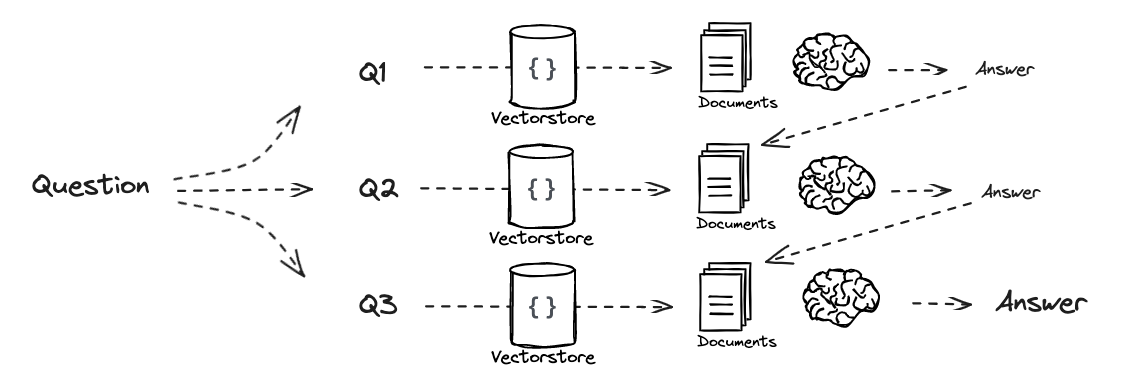

In [13]:
template = """以下是你需要回答的问题：

\n --- \n {question} \n --- \n

以下是可参考的历史问题与答案对（背景消息）：

\n --- \n {q_a_pairs} \n --- \n

以下是与问题相关的补充上下文材料：

\n --- \n {context} \n --- \n

请结合上述提供的上下文内容与历史问答对，回答当前的问题：{question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)


In [15]:
# 循环回答每个子问题，并累积 q_a_pairs
def format_qa_pair(question, answer):
    """格式化问答对"""
    formatted_string = ""
    formatted_string += f"问题：{question}\n答案：{answer}\n\n"
    return formatted_string.strip()

q_a_pairs = ""
for q in questions:
    rag_chain = (
        {
            "context": itemgetter("question") | retriever,
            "question": itemgetter("question"),
            "q_a_pairs": itemgetter("q_a_pairs")
        }
        | decomposition_prompt
        | llm
        | StrOutputParser()
    )
    answer = rag_chain.invoke({"question": question, "q_a_pairs": q_a_pairs})
    q_a_pair = format_qa_pair(q, answer)
    q_a_pairs = q_a_pair + "\n---\n"+  q_a_pair

In [16]:
answer

'下面把流程和可拿到的款项按清楚的步骤列出来，便于你参考并向人事核实具体金额。\n\n一、需走的辞职流程（依据公司员工手册与常见做法）\n1. 提交离职申请\n   - 因你已满一年，按公司规定需提前30天向部门主管提交书面离职申请。\n\n2. 离职面谈与审批\n   - 部门主管收到申请后与你面谈，确认意向并向上级逐级汇报；\n   - 审批流到行政/人事，行政/人事会再进行一次离职面谈并签署意见。\n\n3. 工作交接与物品归还\n   - 获批准后按公司离职程序办理工作交接（需要有接手人或监接人确认交接完成）；\n   - 归还公司财物（如笔记本、手机、名片、钥匙、文件等），并在交接单上签字。\n\n4. 行政/人事办理离职手续\n   - 人事确认交接完成后出具离职证明并进行工资结算（通常在交接完成后若干工作日内结算）。\n\n5. 特别注意\n   - 检查劳动合同中是否有竞业限制或违约条款，按合同履行；\n   - 若有未归还物品或需赔偿的情况，会在结算时扣除相应款项。\n\n二、离职时“能拿到的钱”（通常包含的项目与计算口径）\n最终金额以公司核算为准，通常包括：\n\n1. 到离职日的应发工资\n   - 包括当月已实际工作天数对应的基本工资与绩效部分（公司通常按月薪/日薪折算；公司计薪日可能为30天或21.75天，需向人事确认具体口径）。\n\n2. 已确认的销售提成/绩效\n   - 在你离职前已经满足公司提成发放条件并被确认的提成，应结清；\n   - 尚未满足条件（如回款未到位、合同未生效等）的业绩，很多公司会按规则延后结算或不予结算，具体看销售提成细则。\n\n3. 未休年假折算（如公司允许）\n   - 若你有未休年假且公司政策允许折算，按公司年假折算标准折算为工资并结算；有的公司有最低天数或特殊口径，需确认。\n\n4. 报销等其他应付项\n   - 已提交且符合报销规则的已垫付费用会结算。\n\n5. 合法扣款\n   - 公司可在法律及合同允许范围内扣除应由员工承担的款项，例如未归还公司财物的赔偿、已约定的违约金等。扣款应有明确依据与明细。\n\n三、如何核实与确认最终金额（建议操作）\n1. 提交离职申请前或同时，与主管/人事确认并记录：\n   - 当月工资的计薪口径（按30天或21.75天）；\n   - 绩效/提成的结算规

### 3.2 Answer individually

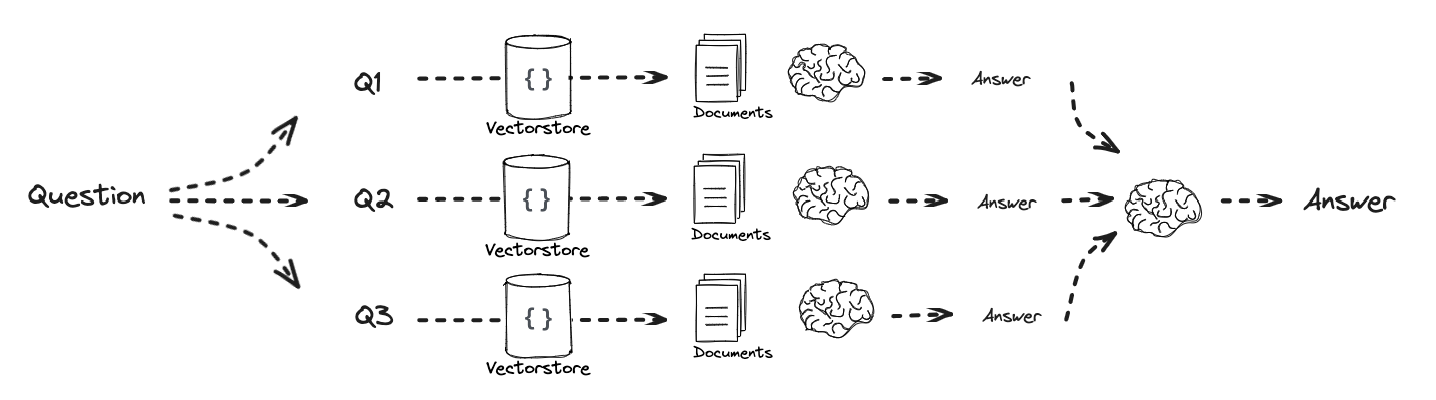

In [17]:
question = "销售人员如果因为客户投诉导致绩效受损，会具体影响哪几部分收入？"

template = """您是一个负责问答任务的助手。请使用检索到的以下上下文内容来回答问题。
如果你不知道答案，只需说明你不知道即可。
问题：{question}\n
上下文：{context}\n
回答："""

prompt_rag = ChatPromptTemplate.from_template(template)

def retrieve_and_rag(question, prompt_rag, sub_question_generator_chain):
    """对每一个子问题分别执行RAG流程"""

    sub_questions = sub_question_generator_chain.invoke({"question": question})

    # 初始化列表，用于存放每个子问题的RAG回答结果
    rag_results = []

    for sub_question in sub_questions:
        # 针对每一个子问题，从向量数据库中检索相关文档片段
        retrieved_docs = retriever.invoke(sub_question)

        # 将检索到的文档作为上下文，连同子问题一起提交给LLM生成回答
        answer = (
            prompt_rag
            | llm
            | StrOutputParser()
        ).invoke({
            "context": retrieved_docs,
            "question": sub_question
        })
        rag_results.append(answer)

    # 返回所有子问题的回答结果列表以及生成的子问题列表
    return rag_results, sub_questions

# 将检索和RAG过程包装在 RunnableLambda 中，以便集成到 LangChain 链中
# 传入原始问题、RAG提示词模板和子问题生成链
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

In [18]:
def format_qa_pairs(questions, answers):
    """格式化问答对"""
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"问题 {i}：{question}\n答案：{answer}\n\n"
    return formatted_string

context = format_qa_pairs(questions, answers)

template = """以下是一组问答对（Q+A）：\n
{context}

请结合以上问答内容，进行综合分析与总结，以回答当前问题：{question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context": context, "question": question})

'基于你提供的问答内容和员工手册中可查到的条款，销售人员因客户投诉导致绩效受损会通过行为考核扣分，进而间接影响其绩效评价与职级判断，从而影响若干具体收入构成。综合分析如下——\n\n1) 绩效工资／绩效相关当期奖金或提成  \n- 原因：员工考核由“业绩（定量）+ 行为（定性）”组成，客户投诉会在行为考核中被扣分，降低综合考核结果。  \n- 可能影响形式：当期的绩效工资、月度/季度绩效奖金、销售提成等以绩效评分或达成率为依据的收入可能被减少、扣发或不达标而无法领取全部金额。  \n- 备注：手册没有列出具体哪些奖金或提成会直接扣减，需参考公司具体佣金/奖金规则以确认受影响的款项和扣减规则。\n\n2) 津贴与短期激励（与绩效挂钩的津贴）  \n- 原因：若某些津贴或短期激励支付以绩效考核结果为条件，综合绩效下降会影响其发放。  \n- 可能影响形式：绩效达标才有的岗位津贴、激励补贴等可能被减少或暂停。\n\n3) 年终奖金／年终分红等一次性激励  \n- 原因：年终调整和奖励通常基于年度绩效考核。行为考核扣分会拉低年度绩效等级。  \n- 可能影响形式：年终奖金金额减少或不发、参与公司分红/分配的资格受限等。\n\n4) 晋升相关待遇（间接影响基本薪资、长期激励）  \n- 原因：晋升与加薪取决于绩效考核结果与职位变动。投诉导致绩效受损会降低晋升和内部升职的可能性。  \n- 可能影响形式：无法晋升就无法获得相应的岗位薪资上调，也可能错失基于更高职级的长期激励资格（如股权、期权授予、长期奖金计划等）。\n\n5) 基本薪资的调整（长期影响）  \n- 原因：手册规定薪资调整在年度绩效考核后根据考核结果决定。较差的绩效会使加薪被减少或取消。  \n- 可能影响形式：下一次工资调整幅度减小或不调整基本工资。\n\n6) 股权/长期激励、长期提成及续约/客户保留相关收入（间接或未明确）  \n- 原因：这些通常与职位、长期业绩或年度考核挂钩。手册未明确将客户投诉如何直接影响这类收入，但逻辑上较差的绩效与未获晋升会降低获得长期激励或续期提成的概率。  \n- 可能影响形式：获得股权/期权、长期激励计划邀请、基于客户留存的长期提成或续约奖励等可能受影响；具体需查公司长期激励与续约提成的细则。\n\n总结性结论：已知的、能够明确推断受影响的收入主要是绩效工资/当期奖金/提成、

---

## <mark>4. Step Back（先退一步问“更一般的问题”）</mark>

核心想法：

有些问题太具体，检索会错过背景知识。

Step Back 先把问题改写成更抽象、更“世界知识友好”的版本，用它去检索背景；再把背景和原问题一起交给 LLM。

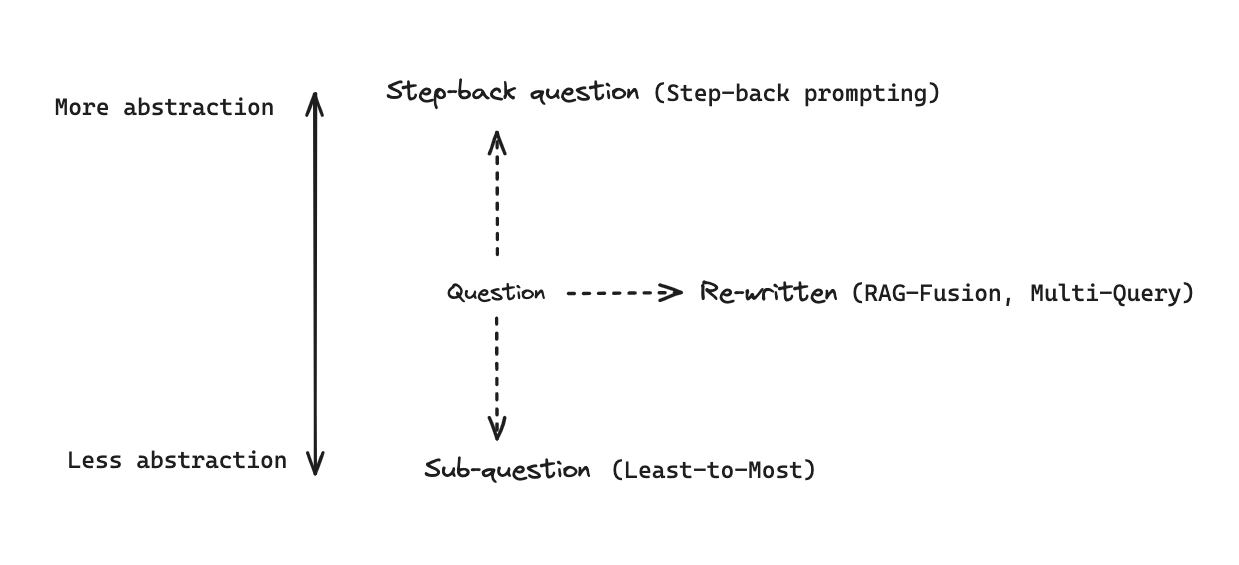

In [19]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

examples = [
    {
        "input": "警察乐队（The Police）的成员可以执行合法的逮捕行动吗？",
        "output": "警察乐队（The Police）的成员拥有哪些职权？",
    },
    {
        "input": "扬·辛德尔（Jan Sindel）出生在哪个国家？",
        "output": "扬·辛德尔（Jan Sindel）的个人生平背景是怎样的？",
    }
]

# 将这些示例转换为消息格式
example_prompt = ChatPromptTemplate.from_messages([
    ("human", "{input}"),
    ("ai", "{output}")
])

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples
)

# 构建最终的提示词模板
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """你是一位百科知识专家。你的任务是将一个具体的问题“退后一步”，改写为一个更具概括性的“退一步问题（step-back question）”，这类问题通常更容易回答。以下是一些改写示例：""",
    ),
    # 插入少样本示例
    few_shot_prompt,
    # 用户的新问题
    ("user", "{question}")
])

In [20]:
generate_queries_step_back = prompt | llm | StrOutputParser()

# 我因为奶奶过世想请假 10 天，可以吗？
# 我想去参加一个行业高端技术培训，公司能报销学费吗？
# 销售部最近想招几个人，流程怎么走？
question = "我能推荐我亲弟弟来我部门当我的助理吗？"

generate_queries_step_back.invoke({"question": question})

'将家人（例如亲弟弟）推荐或聘用到自己所在部门中可能涉及哪些政策、法律和伦理问题？'

In [21]:
# Response prompt
response_prompt_template = """你是一位博学多才的专家，我将向你提问。
你的回答应当全面深入，并且如果以下提供的上下文内容与问题相关，请确保你的回答与这些内容保持一致，不得发生冲突。
如果上下文内容与问题无关，则可以忽略它们。

# 检索到的具体上下文（针对原始问题）：
{normal_context}

# 检索到的背景上下文（针对“退一步”后的概括性问题）：
{step_back_context}

# 原始问题：{question}

回答：
"""

response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

# 构建处理链
chain = (
    {
        # 使用原始问题检索具体的文档片段
        "normal_context": itemgetter("question") | retriever,
        # 使用生成的“退一步”问题检索更广泛的背景原则
        "step_back_context": generate_queries_step_back | retriever,
        # 传递原始问题
        "question": itemgetter("question")
    }
    | response_prompt
    | llm
    | StrOutputParser()
)
chain.invoke({"question": question})

'根据公司员工手册中的“回避原则”，亲戚朋友不能在同一部门任职，直系亲属不能有上下级直属关系。因此，直接把你的亲弟弟安排到你所在部门并担任你的助理，会违反该规定（你们属于直系亲属且存在上下级或直属关系的风险）。\n\n可行的做法有：\n- 如果确实希望推荐他，可先向人力资源部或上级说明情况，请求按公司制度安排。HR可能会建议把他安排到不同部门，或由你不再直接作为他的汇报对象（调整汇报线），以避免直系亲属的上下级关系。\n- 也可以由公司通过内部调配或设置隔离的汇报机制（例如由其他经理直接管理），并让HR进行合规审查和记录。是否允许这种安排取决于公司对“直系亲属上下级关系”的解释与实际执行标准，需经HR或行政部门批准。\n- 如果公司制度是不允许任何同部门或上下级的亲属共事，那么就不能推荐他到你部门，但仍可推荐到公司其他合适岗位。\n\n建议你先联系人力资源或部门负责人，说明情况，听取正式答复并按公司流程办理。这样既遵守公司制度，也能避免潜在的利益冲突或人际关系问题。'

---

## <mark>5. HyDE（Hypothetical Document Embeddings）</mark>

核心想法:

如果用户问题太短/太抽象，直接向量检索时，embedding 表达不够“像一段文档”，召回不稳。
HyDE 做法是：

1. 先让 LLM 写一段“看起来像答案的科学论文段落”（假想文档）
2. 用这段假想文档（更长、更语义密集）去做向量检索
3. 用检索到的真实文档再做最终回答

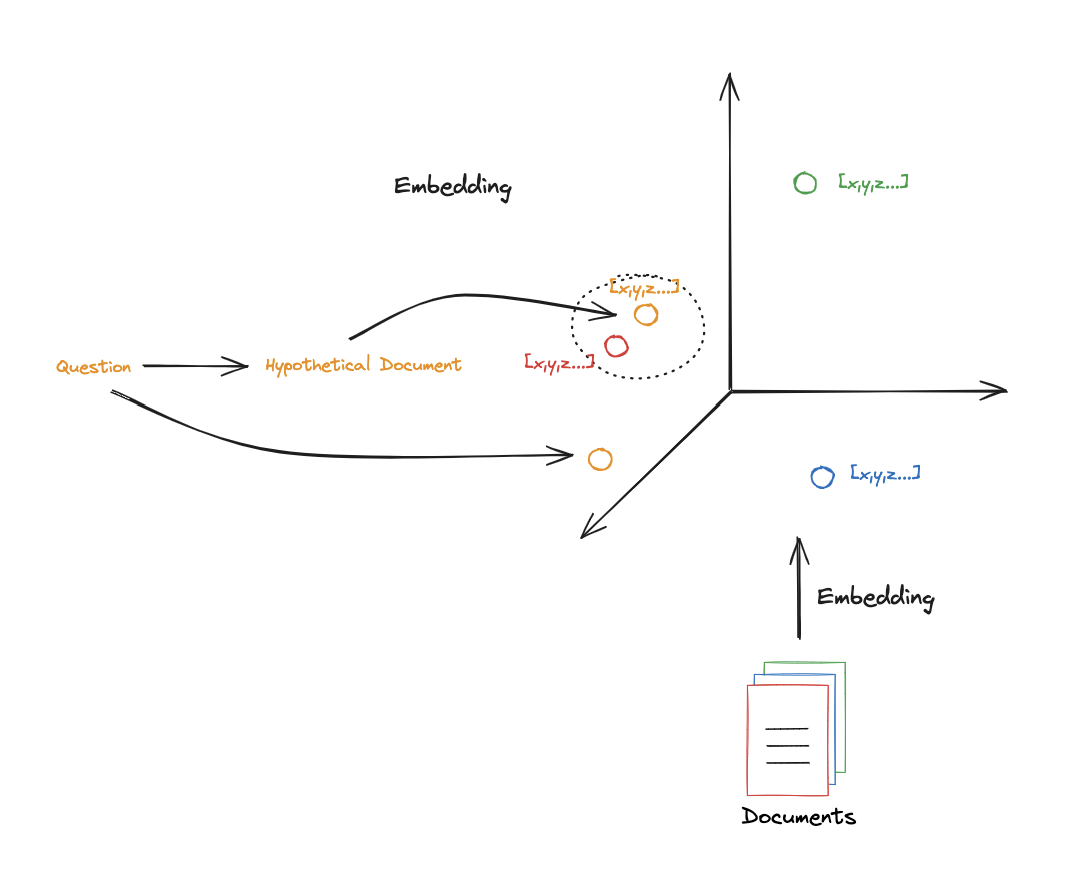

In [22]:
# HyDE 假想文档生成模板
template = """请撰写一篇类似百科全书或规章制度的文字来回答下面的问题。
问题：{question}
段落内容：
"""
prompt_hyde = ChatPromptTemplate.from_template(template)

generate_docs_for_retrieval = (
    prompt_hyde
    | llm
    | StrOutputParser()
)

# 迟到 40 分钟和迟到 20 分钟在处罚上有区别吗？
# 如果我这个月旷工了 2 天，我的工资条会发生什么变化？
question = "公司能帮我交公积金吗？比例是多少？"
generate_docs_for_retrieval.invoke({"question": question})

'公司为员工缴纳住房公积金的责任与比例，依据中华人民共和国相关法律法规和各地执行细则确定。以下内容以规章说明的形式列出，便于查阅与执行。\n\n一、法律依据\n1. 住房公积金管理条例（国务院令）及其实施细则。  \n2. 各省、自治区、直辖市和计划单列市根据国家条例制定的地方性实施办法和缴存细则。  \n3. 当地住房公积金管理中心或住房城乡建设主管部门发布的通知、规定和缴存基数调整公告。\n\n二、公司缴存公积金的义务\n1. 用人单位应当依法为本单位职工按月缴存住房公积金。  \n2. 用人单位未按规定缴存住房公积金的，住房公积金管理中心可责令限期缴存、补缴；构成违法行为的，依法给予行政处罚。  \n3. 用人单位与职工可以通过用人单位代扣代缴职工部分、并按规定比例缴纳单位应缴部分的方式履行缴存义务。\n\n三、缴存基数与缴存比例\n1. 缴存基数  \n   - 缴存基数一般以职工本人上一年度月平均工资为基数确定。  \n   - 各地按照本地区职工月平均工资上下限设定缴存基数上下限，超过上限按上限缴存，低于下限按下限或工资实际数额（依据地方规定）缴存。  \n   - 新入职职工或上一年度工资资料不足的，以试用期工资或入职当月工资作为缴存基数，具体由当地公积金管理中心规定。\n\n2. 缴存比例  \n   - 住房公积金实行单位和个人双向缴存制度，单位和个人通常按相同或不完全相同的比例缴存。  \n   - 国务院和多数地区没有统一的单一全国性固定比例，各地根据经济发展水平和住房公积金制度运行状况确定具体比例区间。通常单位和个人的缴存比例分别在5%—12%之间，常见比例如8%、10%、12%等。  \n   - 部分地区允许差异化缴存比例，且可在法定上下限范围内由单位和职工协商确定，但应报当地区住房公积金管理部门备案或按照当地规定执行。\n\n四、缴存时间与方式\n1. 用人单位应当按月汇缴住房公积金，并在规定的期限内向住房公积金管理中心缴纳当月应缴金额。  \n2. 缴存方式包括单位通过银行代扣代缴、网上申报汇缴等渠道办理；职工个人部分一般由单位从工资中代扣并随单位部分一并缴纳。  \n3. 用人单位变更、停缴或补缴，应按管理中心规定办理手续并接受审查与处理。\n\n五、查询与监督\n1. 职工可通过住房公积金管理中心官网、官方App、营业网点或单位人

In [23]:
retrieval_chain = generate_docs_for_retrieval | retriever
retrieved_docs = retrieval_chain.invoke({"question": question})
retrieved_docs

[Document(metadata={'source': 'E:\\users\\hwy\\LLMs-Technology-Projects\\LangChain_AI_Learning\\data\\员工手册.md'}, page_content='**11、住房公积金**\n\n本公司为全体正式员工按员工工作所在地政府规定的比例缴纳住房公积金。\n\n---\n\n### 绩效考核制度\n\n**1、目的**\n\n为鼓舞销售人员工作热情，提高工作绩效，积极拓展市场，促进公司产品的营销，维护公司的正常发展，特制定本制度。\n\n**2、 原则**'),
 Document(metadata={'source': 'E:\\users\\hwy\\LLMs-Technology-Projects\\LangChain_AI_Learning\\data\\员工手册.md'}, page_content='**5、 薪资及支付方法**\n\n员工薪资及支付方法遵循以下规定：\n\n- 计薪期。员工薪资按月结算，计薪期为发薪当月的第一天至最后一天。\n\n- 发薪日。员工薪资于每月5号发放，员工薪资以银行自动转账方法存入员工个人工资卡。如遇到节假日顺延发放。\n\n**6、薪资计算**\n\n员工薪资计算遵循以下规定：'),
 Document(metadata={'source': 'E:\\users\\hwy\\LLMs-Technology-Projects\\LangChain_AI_Learning\\data\\员工手册.md'}, page_content='**10、社会保险**\n\n本公司为全体正式员工按员工工作所在地政府规定的比例缴纳社会保险金，包括：养老保险、失业保险、工伤保险、医疗保险、生育保险。员工工作所在地地方政府尚未规定缴纳医疗保险的，公司为员工购买商业医疗保险。\n\n**11、住房公积金**'),
 Document(metadata={'source': 'E:\\users\\hwy\\LLMs-Technology-Projects\\LangChain_AI_Learning\\data\\员工手册.md'}, page_content='#### 八、考勤休假\n\n具体规定详见《公司考勤管理制度》。\n\n#### 

In [24]:
template = """您是一个负责问答任务的助手。请使用检索到的以下上下文内容来回答问题。
如果你不知道答案，只需说明你不知道即可。
问题：{question}\n
上下文：{context}\n
回答：
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)
final_rag_chain.invoke({"context": retrieved_docs, "question": question})

'根据公司员工手册中的规定：\n\n- 公司会为全体正式员工按员工工作所在地政府规定的比例缴纳住房公积金（即公司可以帮你缴）。\n- 手册没有写明具体百分比，缴纳比例按你工作所在地的政府规定执行（不同城市/地区比例不同）。\n\n如果需要确切的比例，请告知你的工作所在地或咨询公司人力/财务部门以获得当地规定的具体缴存基数和比例。'